In [1]:
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.signal import argrelextrema
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
from numba import njit,vectorize,double
import math
from numpy.random import default_rng, SeedSequence
from pydub import AudioSegment

C:\Users\torri\miniconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
rng = default_rng()

### Approximating n-dimensional differential equations

In [147]:
def rk4(fs,x0,h,numSteps):
    path = np.zeros((numSteps+1,x0.size))
    path[0] = x0
    def f(xt):
        return np.array(list(map(lambda fi: fi(xt),fs)))
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        path[i+1] = x1
        x0 = x1
    return path

We also need to allow for a version that can be driven by a signal

In [155]:
def drivenrk4(fs,x0,h,driver,signal):
    numSteps = signal.size-1
    xn = x0[driver]
    x0[driver] = signal[0]
    x0 = np.append(x0,xn)
    path = np.zeros((signal.size,x0.size))
    path[0] = x0
    fn = fs[driver]
    fs[driver] = lambda x: 1
    fs = np.append(fs,fn)
    def f(xt):
        return np.array(list(map(lambda fi: fi(xt),fs)))
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        x1[driver] = signal[i+1]
        path[i+1] = x1
        x0 = x1
    return path

In [156]:
def highdimdrivenrk4(fs,x0,h,signal):
    dim = x0.size
    numSteps = signal.size
    path = np.array([x0])
    x0 = np.append(x0,signal[0])
    fs = np.append(fs,lambda x: 1)
    def f(xt):
        return np.array(list(map(lambda fi: fi(xt),fs)))
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        x1[dim] = signal[i]
        path = np.append(path,[x1],axis=0)
        x0 = x1
    return path

### Some sample systems

In [157]:
def lorenz(s,r,b):
    fx = lambda x: s*(x[1]-x[0])
    fy = lambda x: r*x[0]-x[1]-x[0]*x[2]
    fz = lambda x: x[0]*x[1]-b*x[2]
    return np.array([fx,fy,fz])

In [158]:
def cuomoppenheim(s,r,b):
    fx = lambda x: s*(x[1]-x[0])
    fy = lambda x: r*x[0]-x[1]-20*x[0]*x[2]
    fz = lambda x: 5*x[0]*x[1]-b*x[2]
    return np.array([fx,fy,fz])

In [159]:
def rossler(a,b,c):
    fx = lambda x: -(x[1]+z[2])
    fy = lambda x: x[0]+a*x[1]
    fz = lambda x: b+x[2]*(x[0]-c)
    return np.array([fx,fy,fz])

#### A random starting location

In [160]:
def randx(lowbound,highbound):
    off = lowbound
    ma = highbound-off
    offs = np.ones(3)*off
    return offs+(2*rng.random(size=3)-np.ones(3))*ma

Just to prove it works and because I've been working for 7+ hours so i need to sanity check it
i'm going to us the yz projections and we'll see how they line up

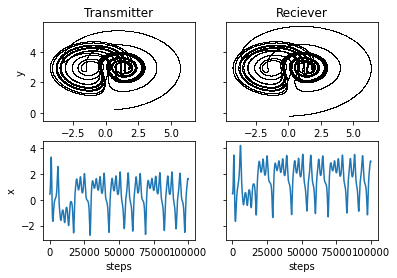

In [162]:
fs = cuomoppenheim(10,60,8/3)
steps = np.int_(1e5)
path0 = rk4(fs,randx(0.3,1),0.001,steps)
xs = path0[:,0]
path1 = drivenrk4(fs,randx(0.3,1),0.001,0,xs)
fig,(ax0,ax1) = plt.subplots(2,2,sharex='row', sharey='row')
ax0[0].set_title('Transmitter')
ax0[0].plot(*path0[:,[1,2]].T,',k')
ax0[0].set_xlabel('z')
ax0[0].set_ylabel('y')
ax0[1].set_title('Reciever')
ax0[1].set_xlabel('z')
ax0[1].plot(*path1[:,[1,2]].T,',k')
time = np.arange(steps+1)
ax1[0].set_xlabel('steps')
ax1[0].set_ylabel('x')
ax1[0].plot(time,path0[:,0])
ax1[1].set_xlabel('steps')
ax1[1].plot(time,path1[:,3])

### Generating chaotic noise
First we convert all of the raw information from our audio file, plus a border on either side so it has a chance to synchronize and then some space at the end so we can hear it working at the end.

In [123]:
def generate_mask(sample_rate,samples,fs,x0,preborder,postborder,persamplerate):
    h = 1/persamplerate
    time = preborder+samples+postborder
    steps = persamplerate*sample_rate*(preborder+message.size+postborder)
    path = r4k(fs,x0,h,preborder+steps+postborder)
    xs = path[:,0]
    mask = AudioSegment(
        xs.tobytes(),
        frame_rate=sample_rate*persamplerate,
        sample_width=xs.dtype.itemsize,
        channels=1
    )
    return mask

Then we add that to the signal we want to send (which has some silence before and after for the aforementioned borders)

In [124]:
def encrypt(audio,fs,x0=randx(3,10),preborder=30,postborder=5,persample=100):
    rate = audio.frame_rate
    preborder = AudioSegment.silent(duration=rate*preborder/1000,frame_rate=rate)
    postborder = AudioSegment.silent(duration=rate*postborder/1000,frame_rate=rate)
    message = preborder + audio + postborder
    mask = generate_mask(rate,audio.frame_count(),fs,x0,preborder,postborder,persample)
    return mask.overlay(message)

Finally we pass that output through another sovler to get the data that we can subtract

In [126]:
def decrypt(signal,fs,driver,x0=randx(3,10),persample=100):
    masked = np.array(signal.get_array_of_samples())
    h = 1/persample
    rate = h*signal.frame_rate
    steps = masked.size
    path = highdimdrivenrk4(fs,x0,h,driver,masked)
    urs = path[:,fs.size]
    message = signal-urs
    out = AudioSegment(
        message.tobytes(),
        frame_rate=sample_rate*persamplerate,
        sample_width=xs.dtype.itemsize,
        channels=1
    )
    return out

## Let's try it!
using
On Hold For You by Kevin MacLeod

Link: https://incompetech.filmmusic.io/song/6928-on-hold-for-you

License: http://creativecommons.org/licenses/by/4.0/

In [127]:
from IPython.display import Audio
jazz = AudioSegment.from_mp3("jazz.mp3")
Audio("jazz.mp3")

C:\Users\torri\miniconda3\lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [128]:
fs = cuomoppenheim(10,60,8/3)
lostjazz = encrypt(jazz,fs)
lostjazz.export("MaskedJazz.wav",format='wav')
Audio("MaskedJazz.wav")

NameError: name 'jazz' is not defined

In [129]:
returnofthejazz = decrypt(lostjazz,fs,0,1)
returnofthejazz.export("DecryptedJazz.wav",format='wav')
Audio("DecryptedJazz.wav")

NameError: name 'lostjazz' is not defined